In [1]:
def load_session(path, sampling_freq, eeg_ch_names):
    # load raw numpy data
    mat = mat73.loadmat(path)
    mat = mat['y']

    # build metadata structure
    ch_names = eeg_ch_names + ['stim1'] 
    ch_types = (['eeg'] * 8) + ['stim']
    info = mne.create_info(ch_names, sfreq=sampling_freq, ch_types=ch_types)

    mat[1:9] = mat[1:9] * 1E-6 # mne expect raw data in Volt, loaded data is in micro volts!
    raw = mne.io.RawArray(mat[1:10], info) # index 1-10 only for EEG and stim channels

    return raw

Creating RawArray with float64 data, n_channels=9, n_times=57728
    Range : 0 ... 57727 =      0.000 ...   225.496 secs
Ready.


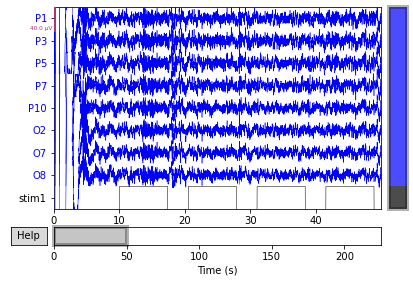

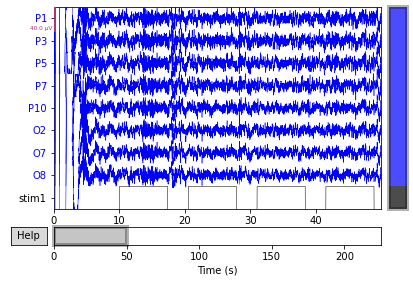

In [9]:
from pathlib import Path
import mat73
import mne


fs = 256
CH_NAMES = ['P1','P3','P5','P7','P10','O2','O7','O8']
subj1_session1 = Path('D:\Desktop\SSVEP/new_data\subject_1_fvep_led_training_1.mat')

raw = load_session(subj1_session1, fs, CH_NAMES)

raw.plot(duration=50, color={'eeg':'blue'})

In [10]:
raw.get_data()

array([[-1.06033557e-03, -4.39110889e-03, -6.67352490e-03, ...,
        -2.11839333e-07, -1.11481071e-06, -1.45659709e-06],
       [-8.56726761e-05, -2.80387939e-04, -1.60418365e-04, ...,
        -4.29037035e-07, -1.45561612e-06, -1.32358170e-06],
       [ 1.95264771e-04,  6.47012390e-04,  3.89287079e-04, ...,
        -2.32556438e-06, -1.93242395e-06, -2.79465526e-07],
       ...,
       [-3.04575867e-04, -1.58394141e-03, -3.58679175e-03, ...,
         2.43617129e-06,  1.07023799e-06,  1.06936848e-06],
       [-6.97454468e-04, -3.07041895e-03, -5.33687256e-03, ...,
         2.22962737e-06,  1.39941478e-06,  1.74224877e-06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

40 events found
Event IDs: [0 1]


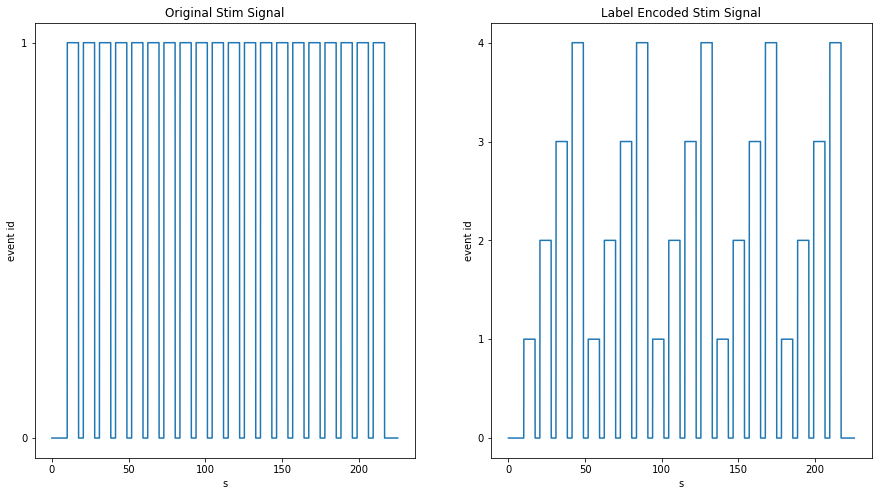

In [11]:
import matplotlib.pyplot as plt
import matplotlib as mpl

def add_labels_to_stim(raw, n_trials=4):
    events = mne.find_events(raw, stim_channel='stim1', output='step')

    on_set_mask = events[:,2] == 1 # stim channel goes from 0 to 1
    on_set_events = events[on_set_mask, 0]

    off_set_mask = events[:,2] == 0  # stim channel goes from 1 to 0
    off_set_events = events[off_set_mask,0]

    raw_copy = raw.copy() # do not effect the original raw signal
    data = raw_copy._data # directly access the underlying numpy data!

    # loop trough events and encode the label as a stim channel event_id
    for i, (on_set, off_set) in enumerate(zip(on_set_events, off_set_events)):
        trial_label = (i % n_trials) +1 # just a trick to avoid looping i in range(1,5)
        data[8, on_set:off_set] = trial_label # modify the stim channel (index 8)

    return raw_copy

raw2 = add_labels_to_stim(raw)

orig_stim, times = raw[8]
modified_stim, times = raw2[8]


fig, axes = plt.subplots(ncols=2, figsize=(15,8))

axes[0].plot(times, orig_stim[0])
axes[0].set_title('Original Stim Signal')
axes[1].plot(times, modified_stim[0])
axes[1].set_title('Label Encoded Stim Signal')

for ax in axes:
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    ax.set_xlabel('s')
    ax.set_ylabel('event id')

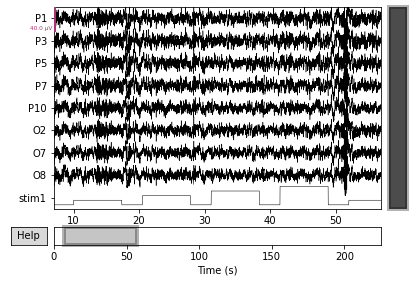

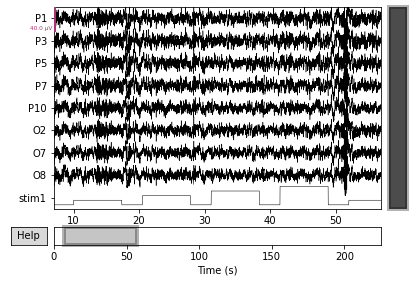

In [15]:
raw2.plot(start=7, duration=50)

In [13]:
import numpy as np

data = raw2.get_data()
np.save(file='D:\Desktop\SSVEP\data_raw.npy', arr=data)

In [14]:
raw2.save("D:\Desktop\SSVEP\data_raw.fif", overwrite=True)

Writing D:\Desktop\SSVEP\data_raw.fif
Closing D:\Desktop\SSVEP\data_raw.fif
[done]
